# SPLAT Demo

### Gene set expression quantification with SPLAT

Spatial Pathway Level Analysis Tool (SPLAT) is a computational method for quantifying the overall expression levels of gene sets for spatial transcriptomics data.
In this demonstration, we shall treat gene sets and "pathways" as synonyms, and we shall refer to spatial locations or individual cells as "spots".

Given spatial transcriptomics data and a user-provided pathway (strictly speaking, a curated set of genes), SPLAT returns a pathway activity score (PAS) for each spot.
SPLAT can also systematically identify spots with elevated pathway activity through a permutation-based hypothesis test.

### Import the `splat` package.

The `splat` Python package can be easily downloaded from source. Simply run the following script in your terminal after ensuring Python and pip are available in your environment. We recommend installing SPLAT in a new Python environment.

```bash
git clone https://github.com/ajy25/splat.git
cd splat
pip install .
cd ..
```

In [1]:
from pathlib import Path
import pandas as pd
import sys

project_directory = Path("__notebook__").resolve().parent.parent
sys.path.append(str(project_directory))

from splat import SPLAT

### Load the spatial transcriptomics data.

In this demo, we'll analyze the 10x Visium BRCA dataset. Let's first load and inspect the gene expression count data. The gene expression dataframe should be of dimension $N \times G$, where $N$ denotes the number of spots, and $G$ denotes the number of genes.

In [2]:
expression_df: pd.DataFrame = pd.read_pickle(
    project_directory / "demo_data" / "10xVisiumBRCA-count_data.pkl"
)
display(expression_df.head())

gene,DVL1,PIK3CD,MTOR,CASP9,WNT4,E2F2,HDAC1,CSF3R,SLC2A1,PTCH2,...,TLR8,VEGFD,ARAF,AR,IL2RG,FGF16,COL4A6,XIAP,FGF13,IKBKG
barcode,,,,,,,,,,,,,,,,,,,,,
GTAGACAACCGATGAA-1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
ACAGATTAGGTTAGTG-1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
TGGTATCGGTCTGTAT-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ATTATCTCGACAGATC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
TGAGATCAAATACTCA-1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Next, let's load and inspect the spatial location data. The location data is of dimension $N \times 2$.
Note: the index of the location dataframe must match the columns of the expression dataframe.

In [3]:
locations_df: pd.DataFrame = pd.read_pickle(
    project_directory / "demo_data" / "10xVisiumBRCA-location_data.pkl"
)
display(locations_df.head())

# note: SPLAT requires spatial locations to be in the form of a DataFrame containing columns "x" and "y"
locations_df = locations_df.rename(columns={"array_row": "x", "array_col": "y"})
display(locations_df.head())

,array_row,array_col
barcode,,
GTAGACAACCGATGAA-1,7,55
ACAGATTAGGTTAGTG-1,7,57
TGGTATCGGTCTGTAT-1,7,59
ATTATCTCGACAGATC-1,7,61
TGAGATCAAATACTCA-1,7,63


,x,y
barcode,,
GTAGACAACCGATGAA-1,7,55
ACAGATTAGGTTAGTG-1,7,57
TGGTATCGGTCTGTAT-1,7,59
ATTATCTCGACAGATC-1,7,61
TGAGATCAAATACTCA-1,7,63


Finally, let's load the pathway data. Pathway data may be stored as a $G \times n_\text{pathways}$ binary matrix.

In [4]:
pathways_df: pd.DataFrame = pd.read_pickle(
    project_directory / "demo_data" / "10xVisiumBRCA-pathways_data.pkl"
)
display(pathways_df.head())

# we can also work with pathways as dictionaries mapping pathway name to list of genes
pathways_dict = {
    pathway: list(pathways_df.index[pathways_df[pathway] == 1])
    for pathway in pathways_df.columns
}
print(pathways_dict)

,KEGG_PATHWAYS_IN_CANCER,WP_INTERACTIONS_BETWEEN_IMMUNE_CELLS_AND_MICRORNAS_IN_TUMOR_MICROENVIRONMENT
DVL1,1,0
PIK3CD,1,0
MTOR,1,0
CASP9,1,0
WNT4,1,0


{'KEGG_PATHWAYS_IN_CANCER': ['DVL1', 'PIK3CD', 'MTOR', 'CASP9', 'WNT4', 'E2F2', 'HDAC1', 'CSF3R', 'SLC2A1', 'PTCH2', 'PIK3R3', 'JUN', 'JAK1', 'WNT2B', 'NRAS', 'PIAS3', 'ARNT', 'NTRK1', 'RXRG', 'FASLG', 'LAMC1', 'LAMC2', 'TPR', 'PTGS2', 'RASSF5', 'LAMB3', 'TRAF5', 'TGFB2', 'WNT9A', 'WNT3A', 'EGLN1', 'FH', 'AKT3', 'SOS1', 'EPAS1', 'MSH2', 'MSH6', 'TGFA', 'CTNNA2', 'TCF7L1', 'PAX8', 'RALB', 'GLI2', 'ITGA6', 'ITGAV', 'STAT1', 'CASP8', 'FZD7', 'FZD5', 'FN1', 'STK36', 'WNT6', 'WNT10A', 'COL4A4', 'VHL', 'PPARG', 'RAF1', 'WNT7A', 'RARB', 'TGFBR2', 'MLH1', 'CTNNB1', 'LAMB2', 'RHOA', 'RASSF1', 'WNT5A', 'APPL1', 'MITF', 'TFG', 'CBLB', 'GSK3B', 'PIK3CB', 'MECOM', 'PLD1', 'PIK3CA', 'DVL3', 'FGF12', 'CTBP1', 'FGFR3', 'PDGFRA', 'KIT', 'CXCL8', 'FGF5', 'MAPK10', 'NFKB1', 'LEF1', 'EGF', 'FGF2', 'HHIP', 'VEGFC', 'CASP3', 'SKP2', 'FGF10', 'ITGA2', 'PIK3R1', 'MSH3', 'APC', 'TCF7', 'WNT8A', 'CTNNA1', 'FGF1', 'CSF1R', 'PDGFRB', 'FGF18', 'MAPK9', 'E2F3', 'RXRB', 'PPARD', 'CDKN1A', 'VEGFA', 'HSP90AB1', 'LAMA4

### Use SPLAT to compute pathway activity scores

This is the simplest use case for SPLAT. Simply inpute the data and generate an 
activity scores report.

SPLAT (info): Identified 334 common genes in the pathway and expression data. 
SPLAT (info): Identified 2518 common spots in the location and expression data. 
SPLAT (info): Normalized expression data with strategy 'normalize-log1p'. 
SPLAT (info): Model initialization complete. 
SPLAT (info): Beginning activity score computation for 2 pathways with 2 jobs. Method 
               used: cpu. 
SPLAT (info): (Job 2: 
               WP_INTERACTIONS_BETWEEN_IMMUNE_CELLS_AND_MICRORNAS_IN_TUMOR_MICROENVIRONMENT) 
               Activity score computation for 
               WP_INTERACTIONS_BETWEEN_IMMUNE_CELLS_AND_MICRORNAS_IN_TUMOR_MICROENVIRONMENT 
               completed in 0.47 seconds. 
SPLAT (info): (Job 1: KEGG_PATHWAYS_IN_CANCER) Activity score computation for 
               KEGG_PATHWAYS_IN_CANCER completed in 1.58 seconds. 


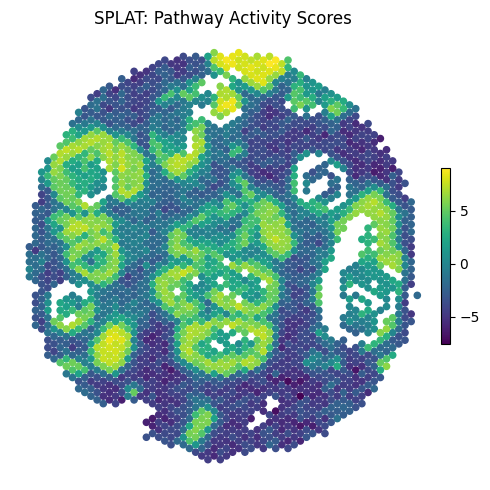

In [5]:
splat_model = SPLAT(
    expression_df=expression_df,
    locations_df=locations_df,
    pathways_df=pathways_df,
    k=6,  # increase k to increase spatial smoothing effect
    normalize_counts_method="normalize-log1p",  # easily normalize counts for non-preprocessed data
)
# compute activity scores for all pathways in pathways_df
splat_report = splat_model.compute_pas(
    beta=0.33,  # increase beta to increase spatial smoothing strength; must be between 0 and 1
    compute_method="cpu",  # use "gpu" for GPU acceleration if available
)
# quickly plot spatial map of activity scores for a specific pathway
figure = splat_report.plot_pas_spatial_map(
    pathway="KEGG_PATHWAYS_IN_CANCER",  # specify the pathway of interest
    size=20,  # dot size
    cmap="viridis",
    figsize=(5, 5),
)  # returns a matplotlib Figure object
display(figure)

You can easily retrieve relevant data in `pd.DataFrame` form from the SPLAT activity scores report.

In [6]:
display(splat_report.pas_df())
display(splat_report.metagene_df(pathway="KEGG_PATHWAYS_IN_CANCER"))

,KEGG_PATHWAYS_IN_CANCER,WP_INTERACTIONS_BETWEEN_IMMUNE_CELLS_AND_MICRORNAS_IN_TUMOR_MICROENVIRONMENT
barcode,,
TATTCGTGCCAGAATA-1,2.016846,0.624290
GCAGCACACAGCCCAG-1,6.067811,-0.944179
AGTCGTGGGCATTACG-1,-5.219044,1.157269
AACATATCAACTGGTG-1,-2.518575,1.654647
TCCGTTAAGCTAATAT-1,0.760685,-1.469731
...,...,...
GAATCTGAACATTCTC-1,5.404247,-1.804650
TGCAGTTTCCTCCCAT-1,1.062613,-1.077724
AGTATTTGGCACGACC-1,0.632619,0.541576


,KEGG_PATHWAYS_IN_CANCER
ERBB2,0.209584
RARA,0.174665
PRKCA,0.174307
CDH1,0.168781
VEGFA,0.157882
...,...
GSTP1,-0.127509
PDGFRB,-0.139655
CSF1R,-0.144318
FOS,-0.167198


You can also work directly with pathways in dictionary form.

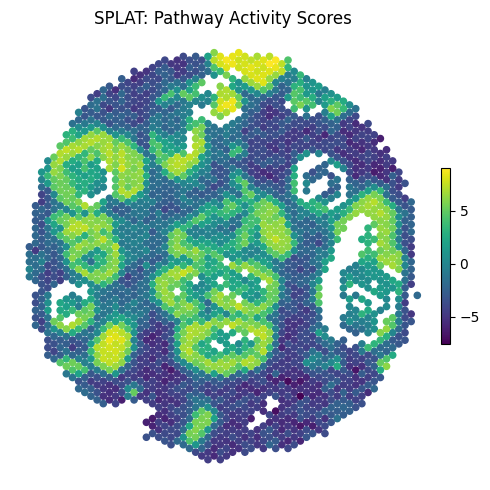

In [7]:
splat_model_no_pathways_df = SPLAT(
    expression_df=expression_df,
    locations_df=locations_df,
    k=6,
    normalize_counts_method="normalize-log1p",
    verbose=False,  # set verbose to False to suppress console output
)
splat_report = splat_model_no_pathways_df.compute_pas(
    pathways_dict=pathways_dict,
    beta=0.33,
    compute_method="cpu"
)
splat_report.plot_pas_spatial_map(
    pathway="KEGG_PATHWAYS_IN_CANCER",
    size=20,
    cmap="viridis",
    figsize=(5, 5)
)

### Use SPLAT to systematically identify spots with significantly elevated pathway activity

In [8]:
splat_model = SPLAT(
    expression_df=expression_df,
    locations_df=locations_df,
    pathways_df=pathways_df,
    k=6,
    normalize_counts_method="normalize-log1p",
)
htest_report = splat_model.htest_elevated_pas(
    pathway="KEGG_PATHWAYS_IN_CANCER", 
    n_permutations=100, # number of random gene sets to sample for the test
    n_jobs=4            # set number of CPUs
)

SPLAT (info): Identified 334 common genes in the pathway and expression data. 
SPLAT (info): Identified 2518 common spots in the location and expression data. 
SPLAT (info): Normalized expression data with strategy 'normalize-log1p'. 
SPLAT (info): Model initialization complete. 
SPLAT (info): Beginning activity score computation for 101 pathways with 4 jobs. Method 
               used: cpu. 
SPLAT (info): (Job 4: random_geneset_2) Activity score computation for random_geneset_2 
               completed in 2.14 seconds. 
SPLAT (info): (Job 3: random_geneset_1) Activity score computation for random_geneset_1 
               completed in 2.14 seconds. 
SPLAT (info): (Job 1: KEGG_PATHWAYS_IN_CANCER) Activity score computation for 
               KEGG_PATHWAYS_IN_CANCER completed in 2.16 seconds. 
SPLAT (info): (Job 2: random_geneset_0) Activity score computation for random_geneset_0 
               completed in 2.18 seconds. 
SPLAT (info): (Job 7: random_geneset_5) Activity score comput

,x,y,pas,p
barcode,,,,
TATTCGTGCCAGAATA-1,34,64,2.016846,0.00
GCAGCACACAGCCCAG-1,38,42,6.067811,0.05
AGTCGTGGGCATTACG-1,51,29,-5.219044,0.99
AACATATCAACTGGTG-1,27,99,-2.518575,0.92
TCCGTTAAGCTAATAT-1,52,100,0.760685,0.04
...,...,...,...,...
GAATCTGAACATTCTC-1,42,64,5.404247,0.02
TGCAGTTTCCTCCCAT-1,40,90,1.062613,0.06
AGTATTTGGCACGACC-1,58,52,0.632619,0.01


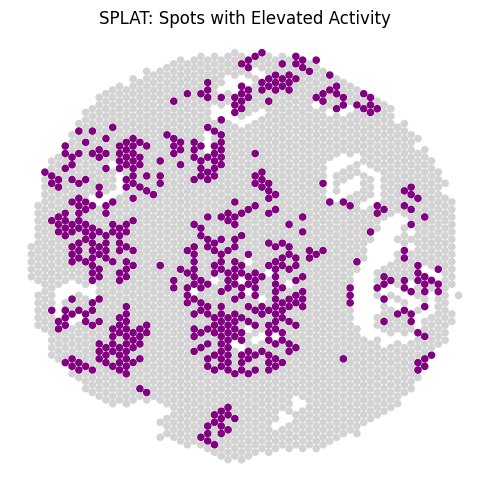

In [9]:
display(htest_report.htest_df())
htest_report.plot_pval_spatial_map(
    size=20,
    significance_threshold=0.05
)